## Spam Classifier

### Naive Bayes Classfier to Predict incoming email as __Spam__ or __Ham__

### 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Iteratively read files
import glob
import os

# For displaying images in ipython
from IPython.display import HTML, display
# Plotting libraries
from IPython.display import SVG
#from graphviz import Source
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

### 2. Load Data
enron email files ref: http://www2.aueb.gr/users/ion/data/enron-spam/

In [2]:
# User defined function to read and store bbc data from multipe folders
def load_data(top_folders,folder_names,root_path):
    doc_list = [] # initiate empty list to store text from files
    
    for name in top_folders:

        fileNames = [path + '/' + name +'/'+ folder + '/*.txt' for path,folder in 
                     zip([root_path]*len(folder_names),folder_names )]

        tags = folder_names
        for docs in fileNames:
            #print(docs)
            #print(type(docs))
            doc = glob.glob(docs) # glob method iterates through all the text documents in a folder
            for text in doc:
                with open(text, encoding='latin1') as f:
                    tag = docs.split('/')[len(docs.split('/'))-2]
                    lines = f.readlines()
                    heading = lines[0].strip()
                    body = ' '.join([l.strip() for l in lines[1:]])
                    doc_list.append([tag, heading, body])
            print("Completed loading data from folder: %s"%tag)

        print("Completed Loading text from %s folder"%name)
        print("------------------------------------------------------------\n")

    return doc_list

In [4]:
os.getcwd()

'/Users/paragpradhan/Documents/Data Science Course/DSB3/5.Text_Mining'

In [3]:
top_folders = ["enron1","enron2","enron3","enron4","enron5","enron6"]
folder_names = ['ham','spam']
docs = load_data(top_folders,folder_names = folder_names, root_path = os.getcwd())

Completed loading data from folder: ham
Completed loading data from folder: spam
Completed Loading text from enron1 folder
------------------------------------------------------------

Completed loading data from folder: ham
Completed loading data from folder: spam
Completed Loading text from enron2 folder
------------------------------------------------------------

Completed loading data from folder: ham
Completed loading data from folder: spam
Completed Loading text from enron3 folder
------------------------------------------------------------

Completed loading data from folder: ham
Completed loading data from folder: spam
Completed Loading text from enron4 folder
------------------------------------------------------------

Completed loading data from folder: ham
Completed loading data from folder: spam
Completed Loading text from enron5 folder
------------------------------------------------------------

Completed loading data from folder: ham
Completed loading data from folder:

In [5]:
docs = pd.DataFrame(docs, columns=['Category', 'Heading', 'Body'])
print(docs.head())
print('\nShape of data is {}\n'.format(docs.shape))
print(docs.info())

  Category                                            Heading  \
0      ham                          Subject: ena sales on hpl   
1      ham  Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...   
2      ham    Subject: hpl nominations for december 28 , 1999   
3      ham               Subject: revised nom - kcs resources   
4      ham      Subject: new production - sitara deals needed   

                                                Body  
0  just to update you on this project ' s status ...  
1  the above referenced meters need to be placed ...  
2  ( see attached file : hpll 228 . xls ) - hpll ...  
3  daren , it ' s in . bob - - - - - - - - - - - ...  
4  daren , fyi . bob - - - - - - - - - - - - - - ...  

Shape of data is (33716, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 3 columns):
Category    33716 non-null object
Heading     33716 non-null object
Body        33716 non-null object
dtypes: object(3)
memory usage: 790.3+ 

### Explore Data

In [6]:
tags_values = docs['Category'].value_counts()
tags_values

spam    17171
ham     16545
Name: Category, dtype: int64

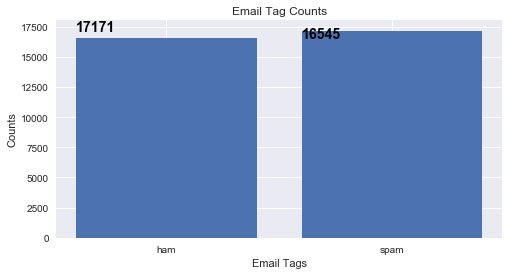

In [7]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(4)
ax.bar(x = tags_values.index ,height = tags_values.values)
#ax.barh(x = df['Gender'], height = np.mean(df.score))
ax.set_title('Email Tag Counts')
ax.set_xlabel('Email Tags')
ax.set_ylabel('Counts')
#ax.set_ylim(top = 0.2)
for i, v in enumerate(tags_values.values):
    ax.text(i-0.4, v + 0.01, s = np.round(v,2), color='black', fontweight='bold',fontsize=14)

In [ ]:
#! pip install wordcloud

In [8]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [9]:
heading_ham = docs[docs["Category"]=="ham"]["Heading"] 
print(heading_ham.shape)
heading_ham[0:5]

(16545,)


0                            Subject: ena sales on hpl
1    Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...
2      Subject: hpl nominations for december 28 , 1999
3                 Subject: revised nom - kcs resources
4        Subject: new production - sitara deals needed
Name: Heading, dtype: object

In [10]:
heading_ham = docs[docs["Category"]=="ham"]["Heading"] # Extract only heading of emails for Ham tags
collapsed_heading_ham = heading_ham.str.cat(sep=' ')

heading_spam = docs[docs["Category"]=="spam"]["Heading"] # Extract only heading of emails for spam tags
collapsed_heading_spam = heading_spam.str.cat(sep=' ') # Combining all the emails into one large text

Word Cloud for Genuine emails


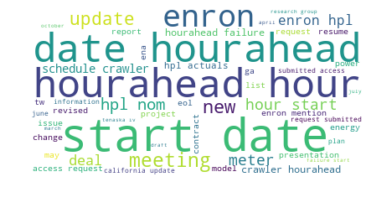


Word Cloud for Spam emails


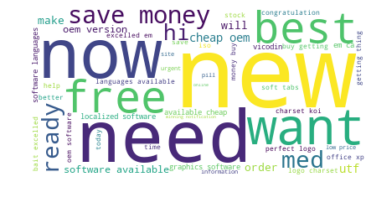

In [11]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Subject","re","fw","fwd"])

print("Word Cloud for Genuine emails")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_ham)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Spam emails")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_spam)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Train Naive Bayes Classifier

### Prediction of Spam emails from Given set of emails

__Naive Bayes Classifier__ It is a classification technique based on Bayes' Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

<img src="images/naive_bayes.png" alt="nb" style="width:60%">

In [12]:
X_train, X_test, y_train, y_test = train_test_split(docs["Body"], docs["Category"],random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape

((26972,), (6744,), (26972,))

In [13]:
# Building Pipeline for raw text transformation
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

In [14]:
model = clf.fit(X_train,y_train)

In [15]:
print("Accuracy of Naive Bayes Classifier is {}".format(model.score(X_test,y_test)))

Accuracy of Naive Bayes Classifier is 0.9869513641755635


In [16]:
# Predict on Test data
y_predicted = model.predict(X_test)
y_predicted[0:10]

array(['spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham',
       'spam', 'spam'], dtype='<U4')

In [17]:
#Confusion Matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted)
np.set_printoptions(precision=2)
cnf_matrix

array([[3220,   56],
       [  32, 3436]])

In [18]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[3220   56]
 [  32 3436]]
Normalized confusion matrix
[[0.98 0.02]
 [0.01 0.99]]


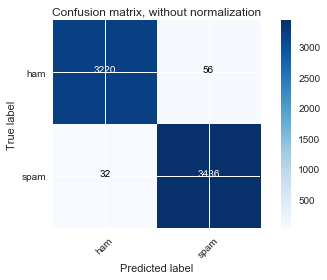

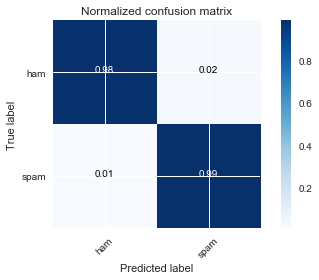

In [19]:
#With Normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ham','spam'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['ham','spam'], normalize=True,title='Normalized confusion matrix')

plt.show()

In [ ]:
import joblib

In [20]:
joblib.dump(model, "email_classfier_V1.0.model")

['email_classfier_V1.0.model']

In [22]:
model1 = joblib.load("email_classfier_V1.0.model")

In [25]:
model1.predict(["Offer for you is 50% off"])

array(['spam'], dtype='<U4')

### Further Exploration

Go through the blog on prediction of sentiments from text using Naive Bayes Classfier
link: https://medium.com/@martinpella/naive-bayes-for-sentiment-analysis-49b37db18bf8